In [3]:
import sys
sys.path.append("./../helper") # to find scripts
from count_helper import counter
from common_imports import *
from helpers import *

### Analyzing counts
The function cc() can be used to access the counts. The following parameters are recognized:
- cc(t='') - counts of a specific term
- cc(fy=) - counts from a specific year
- cc(fj=) - counts from a specific journal
- cc.summarize() - summary of the dimensions of those matrices
- cc.items('t') - gives the terms

In [4]:
cc = counter('wos-soc-20k-titles-all')

Blank counter with name wos-soc-20k-titles-all


In [5]:
cc(t='inequality')

KeyError: 't'

In [5]:
cc(t='inequality', fy=2000)

11

In [6]:
cc.summarize()

[(('fy', 't'), (123, 18456)), (('fj', 't'), (689, 18456)), (('fy',), (123,)), (('t',), (18456,)), (('fj',), (689,))]


### Sorting counts
In the following, I am retrieving the top 150 words in economics

In [9]:
cc.counts[('t',)] # counts of all words

array([35, 118, 49, ..., 1, 1, 1], dtype=object)

In [9]:
topis = np.argsort( cc.counts[('t',)] )[-150:]
print(", ".join( [k for k,i in cc.ids['t'].items() if i in topis] ))

equilibrium, public, goods, economy, costs, theory, firm, investment, effect, monetary, general, regulation, comment, economics, information, control, consumer, wages, evidence, market, risk, determinants, distribution, rates, economies, approach, problem, growth, real, united, states, income, structure, international, credit, dynamic, price, case, models, with, expectations, work, history, labor, earnings, between, social, welfare, energy, some, test, insurance, efficiency, model, alternative, tests, using, from, functions, exchange, pricing, value, life, demand, agriculture, size, money, economic, cost, american, implications, world, policy, behavior, empirical, effects, analysis, time, health, application, finance, utility, rate, taxation, developing, countries, foreign, competition, industry, farm, management, policies, regional, corporate, british, state, financial, note, prices, trade, unemployment, markets, employment, choice, wage, interest, capital, education, under, impact, r

### Limiting the total set of words so that co-occurences can be counted
Counting co-occurences among all words would result in a too-large dataset. That is why we take a limited set of N words for which we count co-occurrences

In [28]:
target_N = 1500

In [29]:
terms_to_keepi = set(np.argsort( cc.counts[('t',)] )[-500:])
terms_to_keep = [k for k,i in cc.ids['t'].items() if i in terms_to_keepi] 

In [30]:
terms = cc.items('t') # all terms
counts = np.array([ cc(t=t) for t in terms ]) # counts of all terms
cdict = {t:cc(t=t) for t in terms} # term/count dictionary

In [31]:
terms_to_keep = sorted(terms, key=lambda x:cdict[x])[-target_N: ] # top 1500 words

In [32]:
len(terms_to_keep)

1500

In [33]:
print(sample(terms_to_keep, 20))

['repeated', 'womens', 'banks', 'relationships', 'wind', 'machinery', 'skills', 'history', 'facts', 'medical', 'racial', 'policy', 'asset', 'expenditure', 'last', 'rents', 'partial', 'matter', 'complete', 'leontief']


18456 terms, total


(array([1.4499e+04, 1.3340e+03, 6.0100e+02, 3.8400e+02, 2.4500e+02,
        1.6800e+02, 1.2400e+02, 1.1800e+02, 1.0200e+02, 7.9000e+01,
        7.1000e+01, 5.6000e+01, 4.3000e+01, 4.1000e+01, 3.4000e+01,
        3.9000e+01, 3.2000e+01, 2.2000e+01, 3.4000e+01, 1.5000e+01,
        2.0000e+01, 1.1000e+01, 1.6000e+01, 1.5000e+01, 1.3000e+01,
        1.2000e+01, 1.2000e+01, 1.1000e+01, 1.5000e+01, 1.3000e+01,
        7.0000e+00, 8.0000e+00, 1.0000e+01, 1.0000e+01, 6.0000e+00,
        9.0000e+00, 7.0000e+00, 1.2000e+01, 7.0000e+00, 8.0000e+00,
        6.0000e+00, 2.0000e+00, 3.0000e+00, 3.0000e+00, 5.0000e+00,
        4.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 5.0000e+00]),
 array([  1.  ,  10.96,  20.92,  30.88,  40.84,  50.8 ,  60.76,  70.72,
         80.68,  90.64, 100.6 , 110.56, 120.52, 130.48, 140.44, 150.4 ,
        160.36, 170.32, 180.28, 190.24, 200.2 , 210.16, 220.12, 230.08,
        240.04, 250.  , 259.96, 269.92, 279.88, 289.84, 299.8 , 309.76,
        319.72, 329.68, 339.64

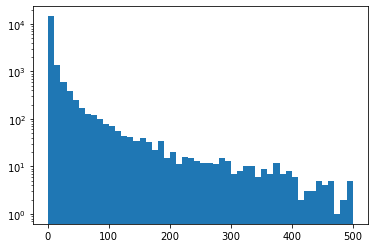

In [34]:
print(len(terms), 'terms, total')
plt.hist(counts[counts<500], bins=50, log=True) # number of words with 500 occurences or more

In [35]:
# Save terms_to_keep
with open('terms_to_keep.econ.pickle', 'wb') as outf:
    pickle.dump(terms_to_keep, outf)

### Counting co-occurrences in the smaller set of words

In [36]:
with open('terms_to_keep.econ.pickle', 'rb') as inf:
    terms_to_keep = pickle.load(inf)

In [37]:
from load_data import wos_econ

148 files
73513 econ articles loaded
190778 soc articles loaded


In [40]:
from collections import Counter

cc = counter()

# wosfile will read each file in the list in turn and yield each record
# for further handling
for i, rec in enumerate(wos_econ):
    
    if i % 10000 == 0:
        print(f'Record {i:,}')
        cc.summarize()
        
    # Records are very thin wrappers around a standard Python dict,
    # whose keys are the WoS field tags.
    # Here we look at the SC field (subject categories) and update our counter
    # with the categories in each record.

    tups = rec['title'].lower().split(" ")
    tups = [t for t in tups if t in terms_to_keep]
    
    count(
        cc,
        values = {
            'fy': int(rec['year']),
            'fj': rec['journal'].lower(),
        },
        terms = tups,
        combinations = [
            ('fy','t'),
            ('fj','t'),
            ('fy',),
            ('t',),
            ('fj',),
            ('t1','t2'),
            #('fj','t1','t2'),
            ('fy','t1','t2')
        ]
    )

Blank counter with no name
Record 0
[]
Record 10,000
[(('fy', 't'), (33, 1738)), (('fj', 't'), (188, 1738)), (('fy',), (33,)), (('t',), (1738,)), (('fj',), (188,)), (('t1', 't2'), (1738, 1738)), (('fy', 't1', 't2'), (33, 1738, 1738))]
Record 20,000
[(('fy', 't'), (63, 1738)), (('fj', 't'), (235, 1738)), (('fy',), (63,)), (('t',), (1738,)), (('fj',), (235,)), (('t1', 't2'), (1738, 1738)), (('fy', 't1', 't2'), (63, 1738, 1738))]
Record 30,000
[(('fy', 't'), (63, 1738)), (('fj', 't'), (235, 1738)), (('fy',), (63,)), (('t',), (1738,)), (('fj',), (235,)), (('t1', 't2'), (1738, 1738)), (('fy', 't1', 't2'), (63, 1738, 1738))]
Record 40,000
[(('fy', 't'), (97, 1738)), (('fj', 't'), (235, 1738)), (('fy',), (97,)), (('t',), (1738,)), (('fj',), (235,)), (('t1', 't2'), (1738, 1738)), (('fy', 't1', 't2'), (97, 1738, 1738))]
Record 50,000
[(('fy', 't'), (97, 1738)), (('fj', 't'), (235, 1738)), (('fy',), (97,)), (('t',), (1738,)), (('fj',), (235,)), (('t1', 't2'), (1738, 1738)), (('fy', 't1', 't2'), 

In [41]:
cc.save_counts('wos-econ-20k-titles-limited-cooc')